In [ ]:
import json
import os.path as osp
import sys
from bertviz import model_view, head_view
import yaml

sys.path.insert(0, osp.abspath('.'))

import argparse
from modules.embedder import *
from utils.train_utils import StateCLEVR, ImageCLEVR, ImageCLEVR_HDF5

AVAILABLE_DATASETS = {
    'DeltaRN': [StateCLEVR],
    'DeltaSQFormer': [StateCLEVR],
    'DeltaQFormer': [StateCLEVR],
    'DeltaSQFormerCross': [StateCLEVR],
    'DeltaSQFormerDisentangled': [StateCLEVR],
    'DeltaSQFormerLinear': [StateCLEVR],
    'DeltaRNFP': [ImageCLEVR, ImageCLEVR_HDF5],
}

AVAILABLE_MODELS = {'DeltaRN': DeltaRN,
                    'DeltaRNFP': DeltaRNFP,
                    'DeltaSQFormer': DeltaSQFormer,
                    'DeltaSQFormerCross': DeltaSQFormerCross,
                    'DeltaSQFormerDisentangled': DeltaSQFormerDisentangled,
                    'DeltaSQFormerLinear': DeltaSQFormerLinear,
                    'DeltaQFormer': DeltaQFormer}

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker

In [3]:
def single_scene_translator(scene: dict, translation: dict, alter_rotation_by=None, alter_position_by=None):
    if alter_position_by is None:
        alter_position_by = lambda x: x

    if alter_rotation_by is None:
        alter_rotation_by = lambda x: x

    image_index = scene['image_index']
    n_objects = len(scene['objects'])

    xs = []
    ys = []
    thetas = []
    colors = []
    materials = []
    shapes = []
    sizes = []
    for obj in scene['objects']:
        xs.append(alter_position_by(obj['3d_coords'][0]) / 3)
        ys.append(alter_position_by(obj['3d_coords'][1]) / 3)
        thetas.append(alter_rotation_by(obj['3d_coords'][2]) / 360)
        colors.append(translation[obj['color']])
        materials.append(translation[obj['material']])
        shapes.append(translation[obj['shape']])
        sizes.append(translation[obj['size']])

    #######################################################
    object_positions_x = torch.FloatTensor(xs + (10 - n_objects) * [0]).unsqueeze(1)
    object_positions_y = torch.FloatTensor(ys + (10 - n_objects) * [0]).unsqueeze(1)
    object_positions_t = torch.FloatTensor(thetas + (10 - n_objects) * [0]).unsqueeze(1)

    object_positions = torch.cat([object_positions_x, object_positions_y, object_positions_t], 1).view(10, 3)
    object_colors = torch.LongTensor(colors + (10 - n_objects) * [0])

    object_shapes = torch.LongTensor(shapes + (10 - n_objects) * [0])
    object_materials = torch.LongTensor(materials + (10 - n_objects) * [0])
    object_sizes = torch.LongTensor(sizes + (10 - n_objects) * [0])

    return image_index, n_objects, object_positions, object_colors, object_shapes, object_materials, object_sizes


def single_question_parser(question: dict, word_replace_dict: dict, q2index: dict, a2index: dict):
    image_index = question['image_index']
    q = str(question['question'])
    a = str(question['answer'])
    if word_replace_dict is None:
        pass
    else:
        for word, replacement in word_replace_dict.items():
            q = q.replace(word, replacement)
            a = a.replace(word, replacement)
    if q2index is None:
        pass
    else:
        q = '<START>' + ' ' + q + ' ' + '<END>'
        tokenized_q = []
        for word in q.split(' '):
            if 'bullet' in word or 'butterfly' in word:
                return image_index, None, None, None
            elif '?' in word or ';' in word:
                tokenized_q.append(q2index[word[:-1]])
                tokenized_q.append(q2index[';'])
            else:
                tokenized_q.append(q2index[word])
        q = torch.LongTensor(tokenized_q + [0] * (50 - len(tokenized_q))).view(50)
    if a2index is None:
        pass
    else:
        a = torch.LongTensor([a2index[a] - 4])

    return image_index, len(tokenized_q), q, a


def kwarg_dict_to_device(data_obj, device):
    if device == 'cpu':
        return data_obj
    cpy = {}
    for key, _ in data_obj.items():
        cpy[key] = data_obj[key].to(device)
    return cpy


def load_encoders():
    with open('../translation_tables.yaml', 'r') as fin:
        translation = yaml.load(fin, Loader=yaml.FullLoader)['translation']
    with open(f'../data/vocab.json', 'r') as fin:
        parsed_json = json.load(fin)
        q2index = parsed_json['question_token_to_idx']
        a2index = parsed_json['answer_token_to_idx']

    return translation, q2index, a2index


def load_model(device, load_from=None):
    if device == 'cuda':
        device = 'cuda:0'
    experiment_name = load_from.split('results/')[-1].split('/')[0]
    config = f'../results/{experiment_name}/config.yaml'
    with open(config, 'r') as fin:
        config = yaml.load(fin, Loader=yaml.FullLoader)

    model = AVAILABLE_MODELS[config['model_architecture']](config)
    model = model.to(device)
    checkpoint = torch.load(load_from)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loading Model of type: {config['model_architecture']}\n")
    model.eval()
    return model


def encode_questions_and_scenes(question, q2index, a2index, scene, translation, alter_rotation_by=None,
                                alter_position_by=None):
    image_index_scene, n_objects, object_positions, object_colors, object_shapes, object_materials, object_sizes = \
        single_scene_translator(scene=scene, translation=translation, alter_rotation_by=alter_rotation_by,
                                alter_position_by=alter_position_by)

    image_index_question, n_tokens, q, a = single_question_parser(question,
                                                                  word_replace_dict={'true': 'yes',
                                                                                     'True': 'yes',
                                                                                     'false': 'no',
                                                                                     'False': 'no'
                                                                                     },
                                                                  q2index=q2index,
                                                                  a2index=a2index)
    if n_tokens is None:
        return 0, 0

    if image_index_scene == image_index_question:
        types = [1] * n_objects + [0] * (10 - n_objects) + [2] * n_tokens + [0] * (50 - n_tokens)
        types = torch.LongTensor(types).view(60)
        positions = torch.LongTensor([0] * 10 + list(range(1, n_tokens + 1)) + [0] * (50 - n_tokens)).view(60)
        x = {'positions': positions.unsqueeze(0),
             'types': types.unsqueeze(0),
             'object_positions': object_positions.unsqueeze(0),
             'object_colors': object_colors.unsqueeze(0),
             'object_shapes': object_shapes.unsqueeze(0),
             'object_materials': object_materials.unsqueeze(0),
             'object_sizes': object_sizes.unsqueeze(0),
             'question': q.unsqueeze(0),
             }
        y = a
    else:
        # print(f"Image index {image_index_scene} and question index {image_index_question} do not match!\n")
        return 1, 1

    return x, y


def fp(model, x, y, device):
    with torch.no_grad():
        x = kwarg_dict_to_device(x, device=device)
        y = y.to(device)
        model = model.to(device)
        y_pred, att_maps, _ = model(**x)
    acc = (y_pred.argmax(1) == y).float().detach().cpu().numpy()
    return acc[0], att_maps

In [4]:
model = load_model(device='cuda', load_from='../results/experiment_linear_sq/mos_epoch_132.pt')

translation, q2index, a2index = load_encoders()

with open(f'../data/CLEVR_val_scenes.json', 'r') as fin:
    parsed_json = json.load(fin)
    scenes = parsed_json['scenes'][0:10]

with open(f'../data/CLEVR_val_questions.json', 'r') as fin:
    parsed_json = json.load(fin)
    questions = parsed_json['questions'][0:100]

Loading Model of type: DeltaSQFormerLinear



In [63]:
# function for plotting the attention weights
def plot_attention_special(layer_attention, tokens):
    for i, head in enumerate(layer_attention):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(4, 2, i+1)
        ax.matshow(head[-4:,], cmap='viridis')
        fontdict = {'fontsize': 10}
        #ax.set_xticklabels([''] + tokens, fontdict=fontdict, rotation=90)
        #ax.set_yticklabels([''] + tokens, fontdict=fontdict)  
        #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        #print(f"Top 5 attended tokens:{}")
    plt.show()
    return head

In [64]:
# function for plotting the attention weights
def plot_attention_objects(layer_attention, tokens):
    for i, head in enumerate(layer_attention):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(4, 2, i+1)
        ax.matshow(head[:10,], cmap='viridis')
        fontdict = {'fontsize': 10}
        #ax.set_xticklabels([''] + tokens, fontdict=fontdict, rotation=90)
        #ax.set_yticklabels([''] + tokens, fontdict=fontdict)  
        #ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        #ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        #print(f"Top 5 attended tokens:{}")
    plt.show()
    return head

In [65]:
acc = 0
eligible = 0
question_counter = 41
scene_counter = 4

In [66]:
scene = scenes[scene_counter]
object_tokens = []
for entry in scene['objects']:
    color = entry['color']
    size  = entry['size']
    material = entry['material']
    shape = entry['shape']
    object_tokens.append(size + ' ' + color + ' ' + material + ' ' + shape)


question = questions[question_counter]
q = question['question']

effective_question = ['<START>'] + [f for f in q.split(' ')] + ['<END>']
question_tokens = object_tokens + effective_question + (50 - len(effective_question)) * ['NULL'] + [f'SP{f+1}' for f in range(4)]
x, y = encode_questions_and_scenes(question, q2index, a2index, scene, translation)

acc_, att_maps = fp(model, x, y, device='cuda')
att_maps = [f.detach().cpu() for f in att_maps]
#model_view(att_maps, question_tokens,display_mode="light")

Layer 1
Special



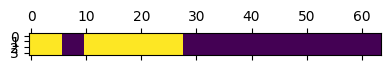

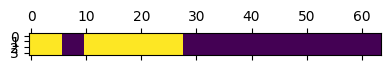

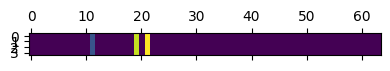

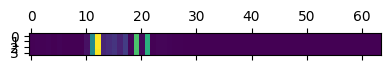

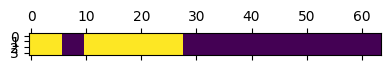

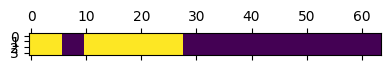

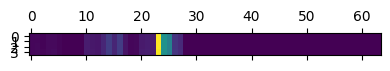

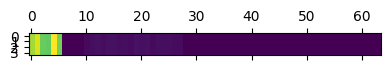

Objects



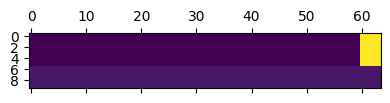

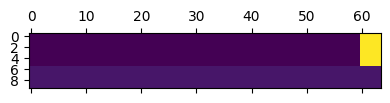

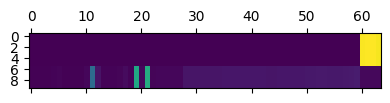

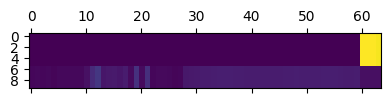

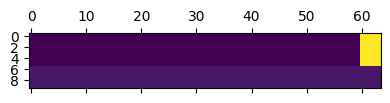

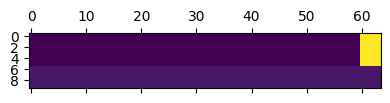

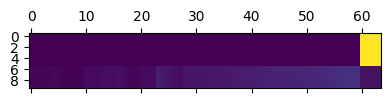

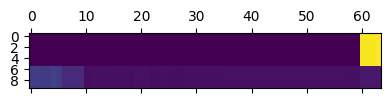



Layer 2
Special



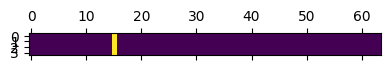

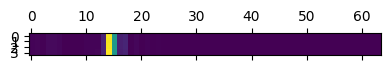

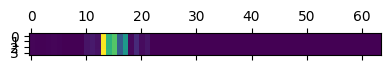

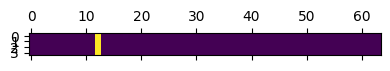

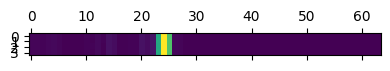

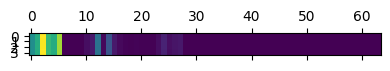

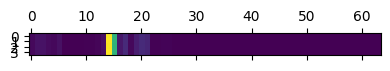

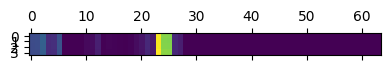

Objects



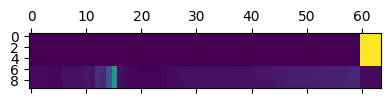

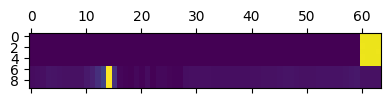

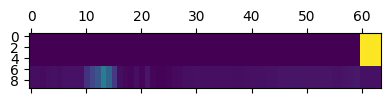

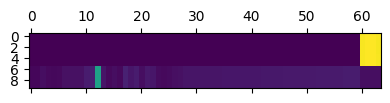

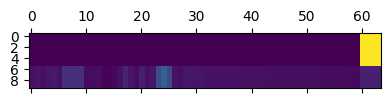

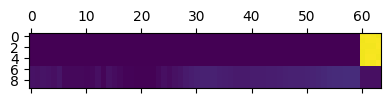

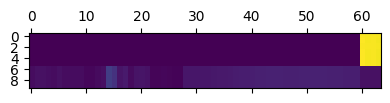

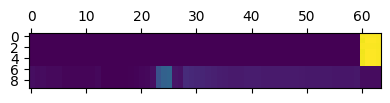



Layer 3
Special



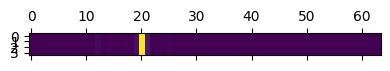

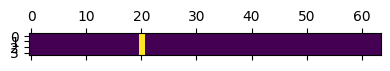

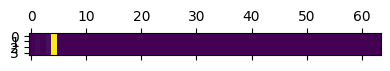

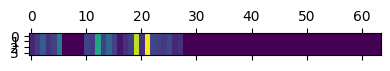

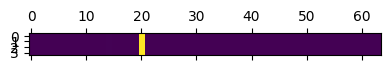

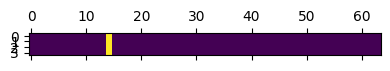

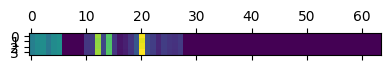

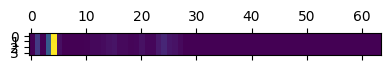

Objects



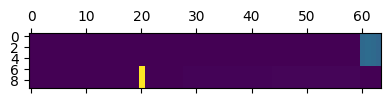

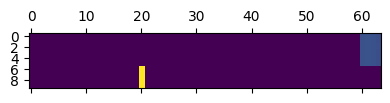

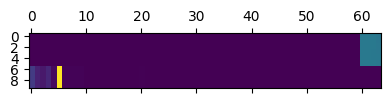

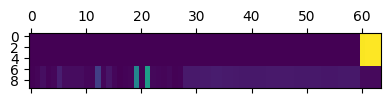

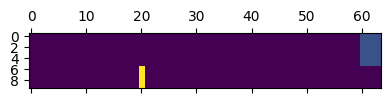

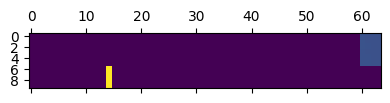

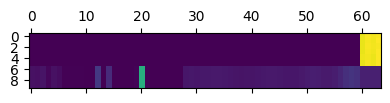

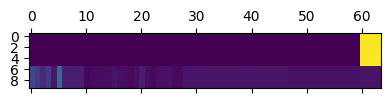



Layer 4
Special



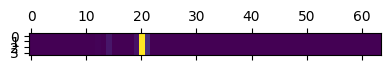

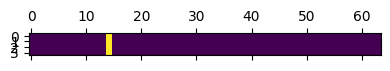

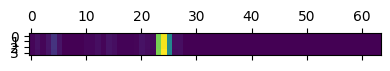

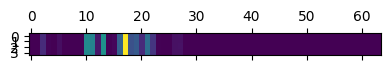

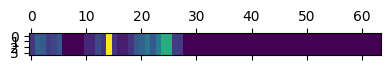

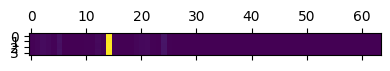

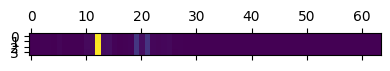

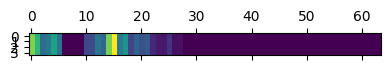

Objects



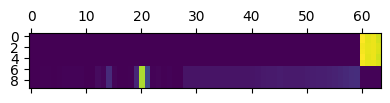

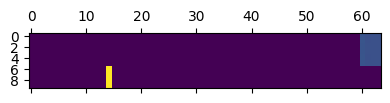

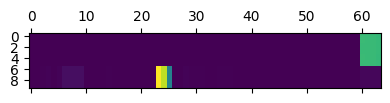

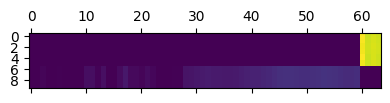

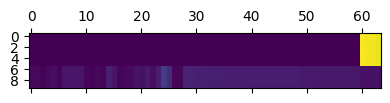

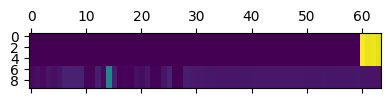

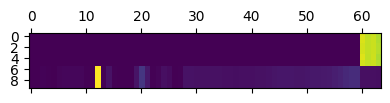

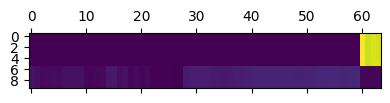



Layer 5
Special



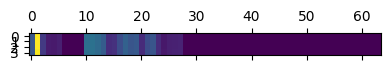

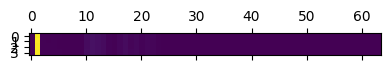

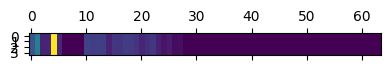

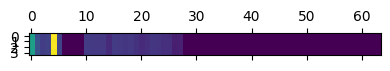

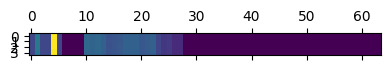

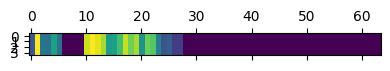

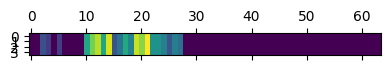

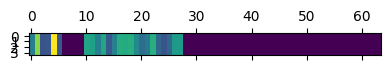

Objects



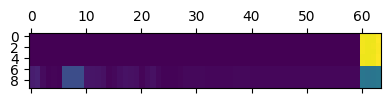

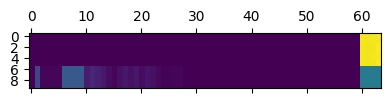

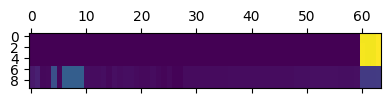

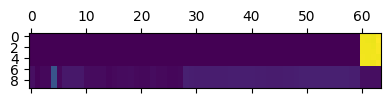

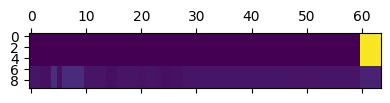

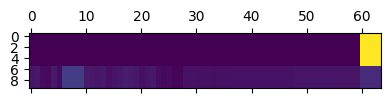

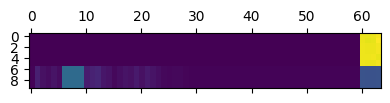

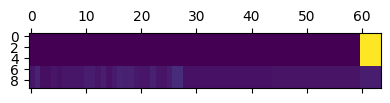

In [67]:
for i,item in enumerate(att_maps):
    print(f"Layer {i+1}")
    item = item[0].numpy()
    print("Special\n")
    plot_attention_special(item, question_tokens)
    print("Objects\n")
    plot_attention_objects(item, question_tokens)
    print('\n')